In [1]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle
import collections
import scipy
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt

from functions_v2 import *


## Load the data

In [2]:
n = 100  # number of image to load

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(n, len(files))  
print("Loading " + str(n) + " images")
# Load color images
imgs = [load_image(image_dir + files[i]) for i in range(n)]
# Import Black and white images
bw_imgs = [load_image_pil(image_dir + files[i], bw=True) for i in range(n)]

print(files[0])
#Load grountruth images
gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


## Data Exploration
An example of the an image and its groundtruth is shown below

Image size = 400,400


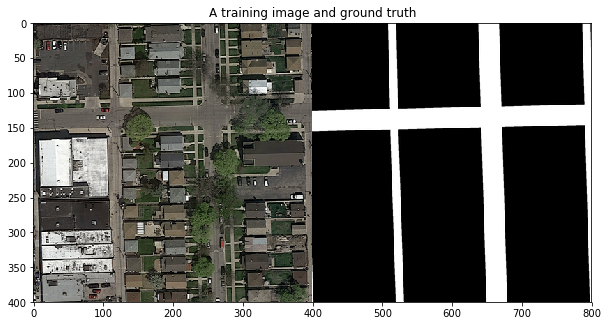

In [3]:
image = imgs[3]
gt_image = gt_imgs[3]
print('Image size = ' + str(image.shape[0]) + ',' + str(image.shape[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.title("A training image and ground truth")
plt.imshow(concatenate_images(image, gt_image), cmap='Greys_r');


We observe that the road we need to label can be a difficult task. The variety of colors and obstacles is high : 
- Trees
- Cars
- Asphalt color

## Patches

There are 625 patches of 16*16 for the image


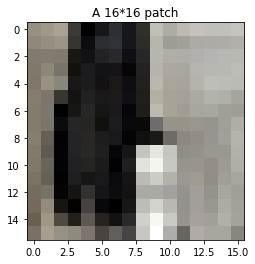

In [4]:
patch_size = 16
img_patches = get_patches(image, patch_size, patch_size, 0)
plt.title('A 16*16 patch')

print("There are", len(img_patches), "patches of 16*16 for the image")
plt.imshow(img_patches[5], cmap='Greys_r');


Our task is to label each of these 16\*16 patch.  
On the example above can be either some obstacle, a car, or an element of a roof.


However, this small size of portion of the image can miss some context. We need to expand this by adding some padding around it. 


## Padding

Instead of taking the raw 16\*16 patch, we can take a larger patch (padded patch) and then classify the 16\*16 center of that expanded patch.

In order to do that on the border of the image, we have to expand it. One of the way to do that is to mirroring the image

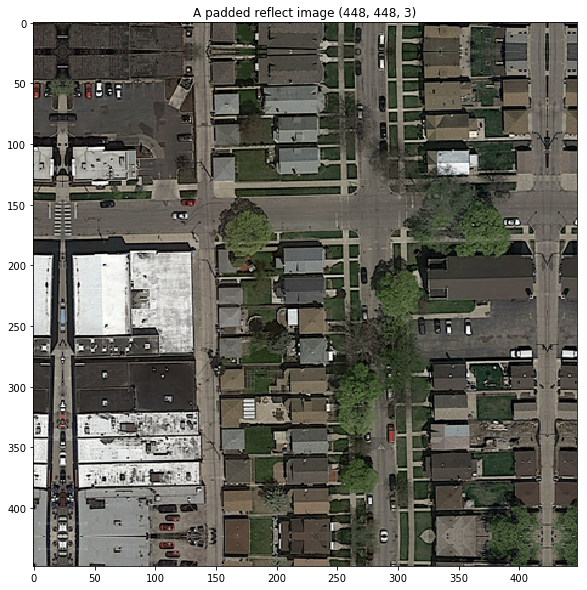

In [5]:
image = imgs[3]
gt_image = gt_imgs[3]

padding = 24
padded_patch_size = patch_size + padding * 2

padded_image = pad_image(image, padding)

fig1 = plt.figure(figsize=(10, 10))
plt.title("A padded reflect image " + str(padded_image.shape))
plt.imshow(padded_image, cmap='Greys_r');


There are 625 patches of 64*64 for the image


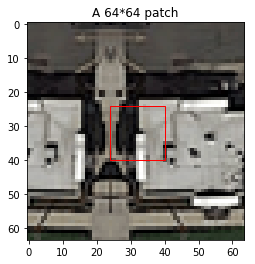

In [6]:
padded_img_patches = get_patches(padded_image, patch_size, patch_size, padding)

print("There are", len(padded_img_patches),
      'patches of ' + str(padded_patch_size) + '*' + str(padded_patch_size) + ' for the image')

fig, ax = plt.subplots(1)
plt.title('A ' + str(padded_patch_size) + '*' + str(padded_patch_size) + ' patch')

plt.imshow(padded_img_patches[5], cmap='Greys_r');
rect = matplotlib_patches.Rectangle((padding, padding), patch_size, patch_size, linewidth=1, edgecolor='r',
                                    facecolor='none')
ax.add_patch(rect)
plt.show()


Now we can see clearly that the center (the image inside the red square)of this padded image is not a road.

## Data augmentation
The dataset contains only 100 examples.
In order to increase the dataset, we can do the following transformation : 
- 90 degree rotation
- Horizontal flip
- Vertical flip

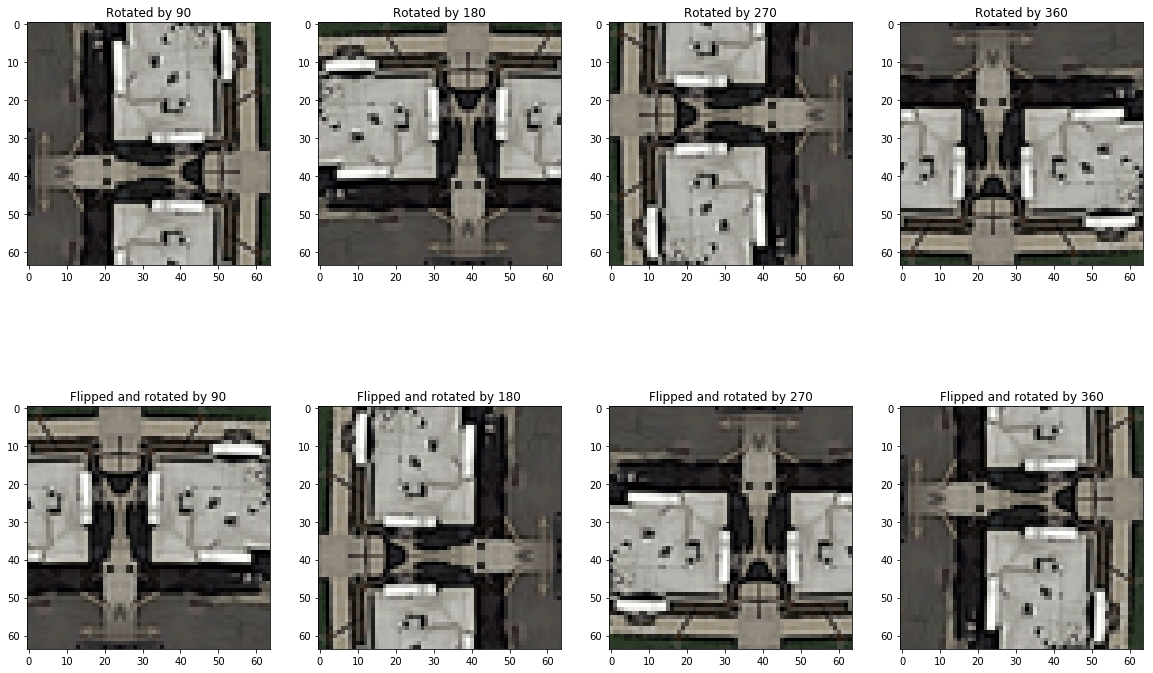

In [7]:
image_to_transform = padded_img_patches[5]
transformed_images = [np.rot90(image_to_transform, i + 1) for i in range(4)]

for i in range(4):
    transformed_images.append(np.rot90(np.flip(image_to_transform, 0), i))

plt.figure(figsize=(20, 20))
columns = 4
for i, transformed_image in enumerate(transformed_images):
    plt.subplot(len(transformed_images) / columns + 1, columns, i + 1)

    if i < 4:
        plt.title('Rotated by ' + str((i + 1) * 90))
    else:
        plt.title('Flipped and rotated by ' + str((i - 3) * 90))

    plt.imshow(transformed_image)


## Black and white image
The idea of using black and white images is that it reduces the amount of data by a factor of 3, due to going from 3 layers (RGB) to just one

Image size = 400,400


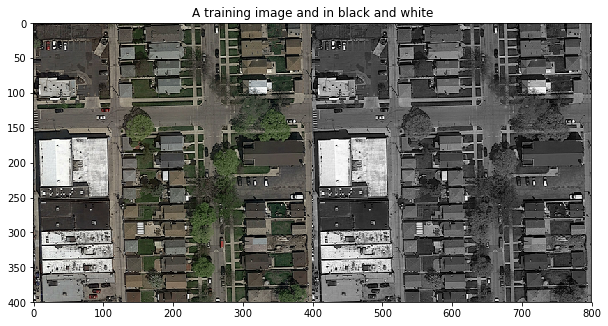

In [8]:
image = imgs[3]
bw_image = bw_imgs[3]
print('Image size = ' + str(image.shape[0]) + ',' + str(image.shape[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.title("A training image and in black and white")
plt.imshow(concatenate_images(image, bw_image), cmap='Greys_r');


## Scharr edge detection
Scharr edge detection is a filtering technique used to find edges in the image, obtaining a black and white image where the gradients are shown (edges)

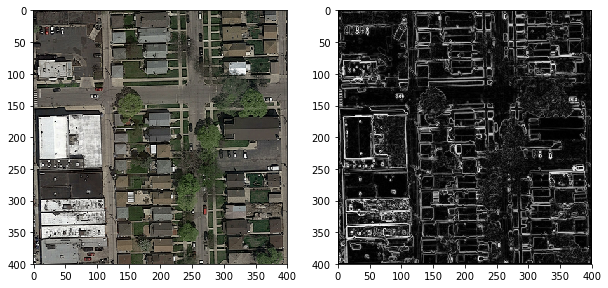

In [9]:
from skimage.filters import scharr

bw = bw_imgs[3]
im = imgs[3]

elevation_map = scharr(bw)

fig1 = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im);
plt.subplot(1, 2, 2)
plt.imshow(elevation_map, cmap='Greys_r');



## ZCA whitening

ZCA whitening is a technique similar to PCA, used to eliminate correlated information and keep the most important values. The difference with PCA is that dimensionality is not reduced

(100, 64, 64, 3)
(100, 12288)
ZCA batch 1 out of 10
ZCA batch 2 out of 10
ZCA batch 3 out of 10
ZCA batch 4 out of 10
ZCA batch 5 out of 10
ZCA batch 6 out of 10
ZCA batch 7 out of 10
ZCA batch 8 out of 10
ZCA batch 9 out of 10
ZCA batch 10 out of 10

ZCA Matrix shape = (10, 10)


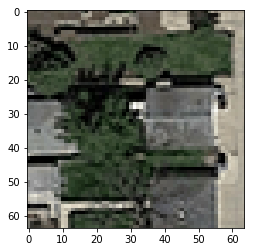

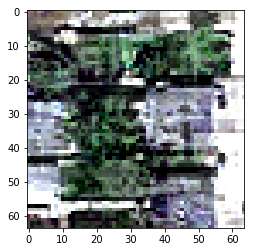

In [10]:

size = 64
n_batch = 10

ims = np.array(imgs[0:100])
ims = ims[:,0:size,0:size,:]
print(ims.shape)
    
ZCAMatrix, zca = zca_whitening(ims, size, size, n_batch, bw = False)
show_ZCA(ims[0], size, size)
show_ZCA(zca[0], size, size)
